In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/prichter/Documents/selenobot/src/')

# Detection task

"Detection task" refers to the ability of the classifier to identify a sequence as either an erroneously-truncated selenoprotein, or a full-length non-selenoprotein. For this task, we used full-length negative normal proteins as negative test cases. The negative cases did *not* include full-length selenoproteins; we are basing this project on the observation that selenoproteins are misidentified, so full-length selenoproteins will not be present in the data we use to validate the model. The positive cases consisted of selenoproteins truncated at the *first* selenocysteine residue only. 

In [3]:
# Define the data and figure directories. 
DATA_DIR = '/home/prichter/Documents/selenobot/data/uniprot_2023_03/detect' 
FIGURE_DIR = '/home/prichter/Documents/selenobot/figures/'

In [4]:
from src.classifiers import EmbeddingClassifier, AacClassifier
from src.dataset import get_dataloader
from src.utils import csv_ids, csv_labels
import src.plot as plot

import os
import matplotlib.pyplot as plt
import seaborn as sns

/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-17 11:57:22.769932: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-17 11:57:22.797364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 11:57:23.223161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

In [5]:
# Paths where the train and test data are stored. 
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')
val_path = os.path.join(DATA_DIR, 'val.csv')

# First load the data into a dataset object. 
train_dataloader = get_dataloader(train_path, batch_size=2048)
val_dataloader = get_dataloader(val_path, batch_size=2048)
# test_dataloader = get_dataloader(test_path, batch_size=1024)

## Testing the benchmark

In [10]:
# First, try training with no other weight, to get a sense of how many epochs to use.
model = EmbeddingClassifier(latent_dim=1024) 
# model = EmbeddingClassifier(1024)

I am curious about how the weight passed into the `WeightedBCELoss` will affect the performance on batches with selenoprotein relative to batches without selenoprotein. For now, I will test out different values on the `AacClassifier`, mostly to see if there *are* any loss function weights which might allow the model to decrease training loss on batches with and without selenoproteins simultaneously (or if this method of binary classification simply isn't sufficient). Based on some preliminary runs, it seems as though around 20 epochs is enough time for the `AacClassifier` to get about as good as it will get, so I will stick with this number for now. 

In [11]:
# aac_reporters = []
# for bce_loss_weight in [1, 10, 100, 1000, 10000, 100000]:
#     model.reset() # Reset the model weights. 
#     aac_reporter = model._train(train_dataloader, val=test_dataloader, epochs=1, lr=0.001, bce_loss_weight=bce_loss_weight)
#     aac_reporters.append(aac_reporter)
#     break

model.reset()
reporter = model._train(train_dataloader, val=val_dataloader, epochs=15, lr=0.001, bce_loss_weight=1) 

classifiers.Classifier.train_: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it, val_acc=0.99]


In [12]:
import sklearn
import numpy as np
tn, fp, fn, tp = np.ravel(sklearn.metrics.confusion_matrix(*model.predict(val_dataloader)))

print('true negative', tn)
print('false positive', fp)
print('false negative', fn)
print('true positive', tp)

# true negative 8389
# false positive 695
# false negative 3
# true positive 25

true negative 8381
false positive 33
false negative 11
true positive 687


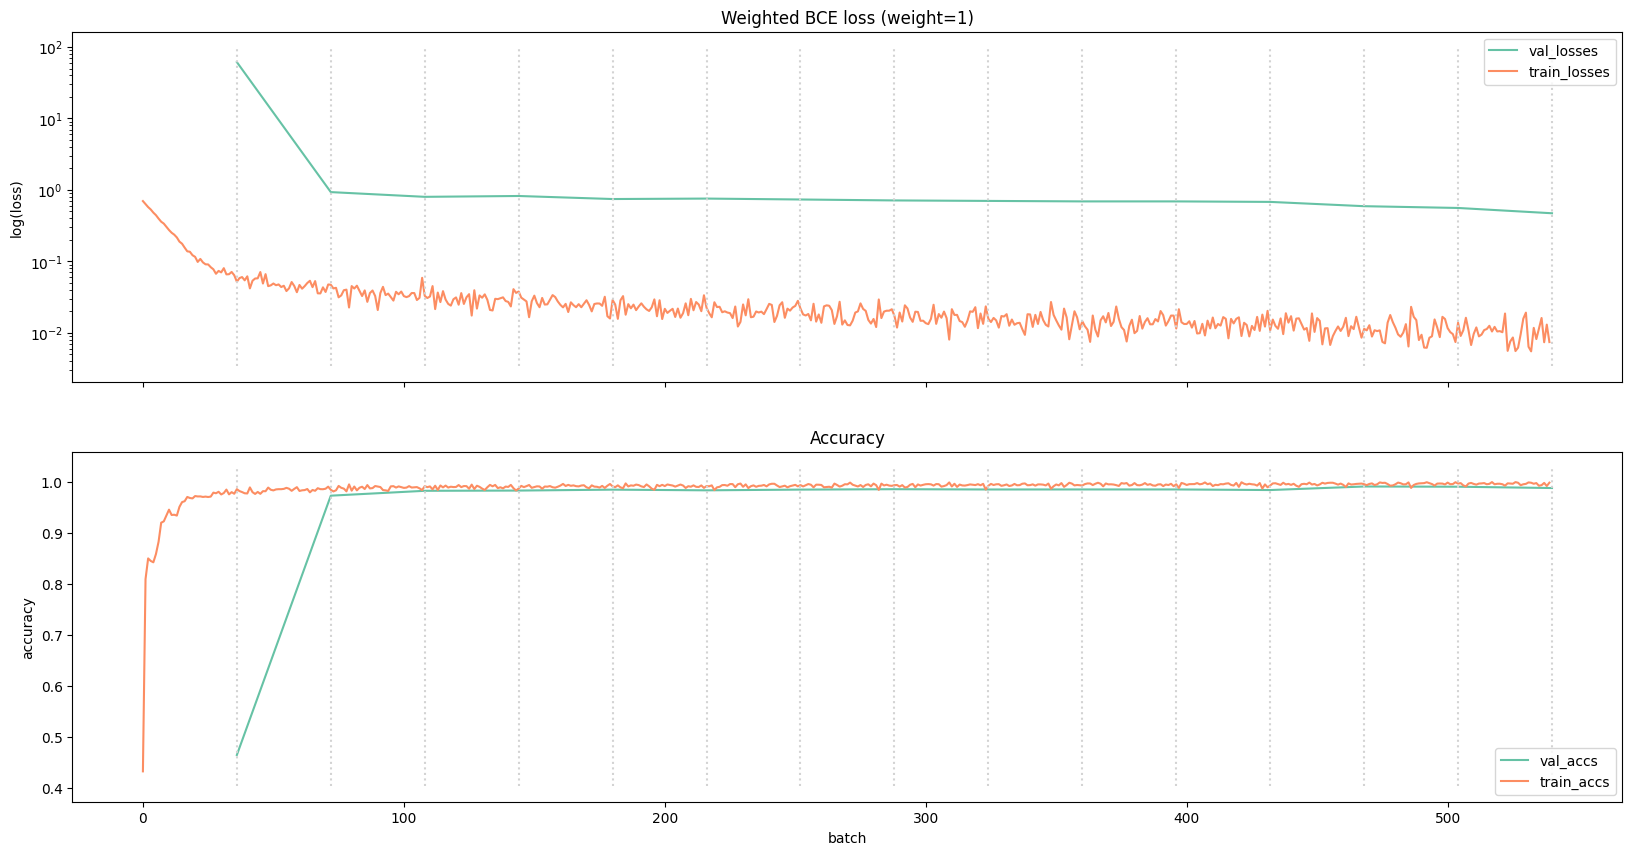

In [13]:
plot.plot_train_(reporter, path='test.png')